In [4]:
import numpy as np
import gc
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib as mpl
#from sklearn.neighbors import KDTree
import threading
from numpy import linalg as LA
from sympy import Plane, Point3D
import pandas as pd
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import math
import copy
import sys
import os
from os.path import isfile, join
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
import math

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='stixgeneral'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 20
plt.rc('figure', facecolor='w')

## Constants in cgs unites
G=6.67408e-8
H=67.26*3.2408e-20
k_B=1.38064852e-16
M_sun=1.99e+33
pc=3.086e18
kpc=3.086e21
Mpc=3.086e24
Gyr=365*24*3600*1e9
Myr=365*24*3600*1e6
yr=365*24*3600
m_p=1.6726219e-24
AU=1.496e13

h=0.6774

# 2.

In [315]:
#constants
size=200
xlength=2
gamma=1.4
CFL=0.5

time=0

q_0=4
q_1=0.5


# empty arrays, one ghost cell at each end
rho0=np.zeros(size)
rho1=np.zeros(size)
m0=np.zeros(size)
m1=np.zeros(size)
p0=np.zeros(size)
p1=np.zeros(size)
q0=np.zeros(size)
q1=np.zeros(size)

v0=np.zeros(size+1)
v1=np.zeros(size+1)

x0=np.linspace(0,xlength,size+1)
x1=np.zeros(size+1)


# initialization
xmax=0.75
imax=int(size*xmax/xlength+1)

rho0[:imax]=1
p0[:imax]=1

rho0[imax:]=0.125
p0[imax:]=0.1


m0[:]=rho0[:]*(x0[-1]-x0[0])/size

v0[:]=0

e0=p0/rho0/(gamma-1)
e1=e0

cs0=np.sqrt(p0/rho0)
cs1=np.sqrt(p0/rho0)

q0[:]=0
        


for i in range(1000): #10000
    # timestep (n) - CFL condition
    delta_t=CFL*min(np.min((x0[1:]-x0[:-1])/(np.abs(v0[:-1])+cs0)), np.min((x0[1:]-x0[:-1])/(np.abs(v0[1:])+cs0)))
    #if i == 0:
        #delta_t*=0.0001
    #print(delta_t, time)


    # evolution (n+1/2)
    v1[1:-1]=v0[1:-1]-delta_t*(p0[1:]-p0[:-1]+q0[1:]-q0[:-1])/(0.5*(m0[:-1]+m0[1:]))
    v1[0]=0 # boundary
    v1[-1]=0 # boundary
    #time+=delta_t

    
    # timestep (n+1/2) - CFL condition
    #delta_t=CFL*np.min((x0[1:]-x0[:-1])/(np.abs(v1[1:])+cs0))
    #print(delta_t, time)


    # evolution (n+1)
    x1[:]=x0+delta_t*v1
    rho1[:]=m0/(x1[1:]-x1[:-1])
    #e1[:]=e0-(p0+q0)*(1/rho1-1/rho0)
    e1[:]=(e0-(p0/2+q0)*(1/rho1-1/rho0))/(1+rho1*(gamma-1)/2*(1/rho1-1/rho0))
    p1[:]=e1*rho1*(gamma-1)
    cs1[:]=np.sqrt(p1/rho1)
    time+=delta_t
    
    
    # artificial viscosity
    for j in range(size):
        if (v1[j+1]-v1[j])/(x1[j+1]-x1[j]) < 0:
            q1[j]=(q_0*(v1[j+1]-v1[j])**2-q_1*(v1[j+1]-v1[j]))*cs1[j]/(0.5*(1/rho1[j]+1/rho0[j]))
        else:
            q1[j]=0
    

    # ready to iterate
    rho0=rho1
    p0=p1
    q0=q1
    e0=e1
    cs0=cs1

    v0=v1
    x0=x1

    
    if time>0.245:
        print('End:',i)
        break

        
print('Time:',time)

End: 305
Time: 0.24501793991738946


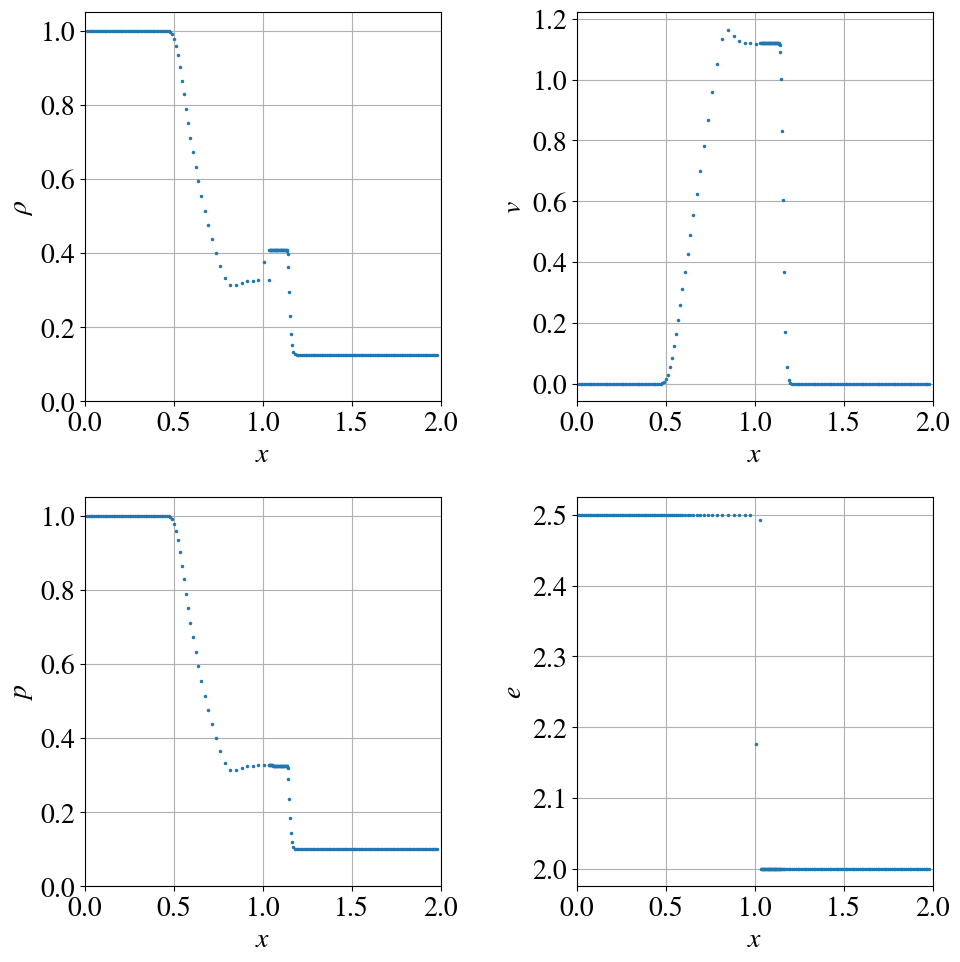

In [314]:
fig=plt.figure(figsize=(10,10),dpi=100)
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)

ax1.plot(x0[1:-2],rho0[1:-1],'.',markersize=3)
ax2.plot(x0[1:-2],v0[1:-2],'.',markersize=3)
ax3.plot(x0[1:-2],p0[1:-1],'.',markersize=3)
ax4.plot(x0[1:-2],e0[1:-1],'.',markersize=3)

ax1.set_xlim(0,2)
ax2.set_xlim(0,2)
ax3.set_xlim(0,2)
ax4.set_xlim(0,2)
ax1.set_ylim(0,1.05)
ax3.set_ylim(0,1.05)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$\rho$')
ax2.set_xlabel('$x$')
ax2.set_ylabel(r'$v$')
ax3.set_xlabel('$x$')
ax3.set_ylabel(r'$p$')
ax4.set_xlabel('$x$')
ax4.set_ylabel(r'$e$')

plt.tight_layout()

# 2. (a)

<font size="5">
Compared to the analytic solutions, my numerical result is missing some features.<br>
Density should have four step-shaped discontinuities but here, it jumps at $x=1$.<br>
Though pressure and density show similar shape will the analytic solutions, because of the density jump, energy does not jump in front of rarefaction wave.<br>
Also, rarefaction wave is poorly resolved.</font>

In [333]:
#constants
size=800
xlength=2
gamma=1.4
CFL=0.1

time=0

q_0=4
q_1=0.5


# empty arrays, one ghost cell at each end
rho0=np.zeros(size)
rho1=np.zeros(size)
p0=np.zeros(size)
p1=np.zeros(size)
q0=np.zeros(size)
q1=np.zeros(size)

m0=np.zeros(size)

v0=np.zeros(size+1)
v1=np.zeros(size+1)

x0=np.linspace(0,xlength,size+1)
x1=np.zeros(size+1)


# initialization
xmax=0.75
imax=int(size*xmax/xlength+1)

rho0[:imax]=1
p0[:imax]=1

rho0[imax:]=0.125
p0[imax:]=0.1


m0[:]=rho0[:]*(x0[-1]-x0[0])/size

v0[:]=0

e0=p0/rho0/(gamma-1)
e1=e0

cs0=np.sqrt(p0/rho0)
cs1=np.sqrt(p0/rho0)

q0[:]=0
        


for i in range(10000): #10000
    # timestep (n) - CFL condition
    delta_t=CFL*min(np.min((x0[1:]-x0[:-1])/(np.abs(v0[:-1])+cs0)), np.min((x0[1:]-x0[:-1])/(np.abs(v0[1:])+cs0)))
    #if i == 0:
        #delta_t*=0.0001
    #print(delta_t, time)


    # evolution (n+1/2)
    v1[1:-1]=v0[1:-1]-delta_t*(p0[1:]-p0[:-1]+q0[1:]-q0[:-1])/(0.5*(m0[:-1]+m0[1:]))
    #v1[1:-2]=v0[1:-2]-delta_t*(p0[1:-1]-p0[:-2]+q0[1:-1]-q0[:-2])/(0.5*(m0[2:]+m0[1:-1]))
    v1[0]=0 # boundary
    v1[-1]=0 # boundary
    v1[-2]=0 # boundary
    #time+=delta_t

    
    # timestep (n+1/2) - CFL condition
    #delta_t=CFL*np.min((x0[1:]-x0[:-1])/(np.abs(v1[1:])+cs0))
    #print(delta_t, time)


    # evolution (n+1)
    x1[:]=x0+delta_t*v1
    rho1[:]=m0/(x1[1:]-x1[:-1])
    #e1[:]=e0-(p0+q0)*(1/rho1-1/rho0)
    e1[:]=(e0-(p0/2+q0)*(1/rho1-1/rho0))/(1+rho1*(gamma-1)/2*(1/rho1-1/rho0))
    p1[:]=e1*rho1*(gamma-1)
    cs1[:]=np.sqrt(p1/rho1)
    time+=delta_t
    
    
    # artificial viscosity
    for j in range(size):
        if (v1[j+1]-v1[j])/(x1[j+1]-x1[j]) < 0:
            q1[j]=(q_0*(v1[j+1]-v1[j])**2-q_1*(v1[j+1]-v1[j]))*cs1[j]/(0.5*(1/rho1[j]+1/rho0[j]))
        else:
            q1[j]=0
    

    # ready to iterate
    rho0=rho1
    p0=p1
    q0=q1
    e0=e1
    cs0=cs1

    v0=v1
    x0=x1

    
    if time>0.245:
        print('End:',i)
        break

        
print('Time:',time)

End: 6413
Time: 0.2450087664347872


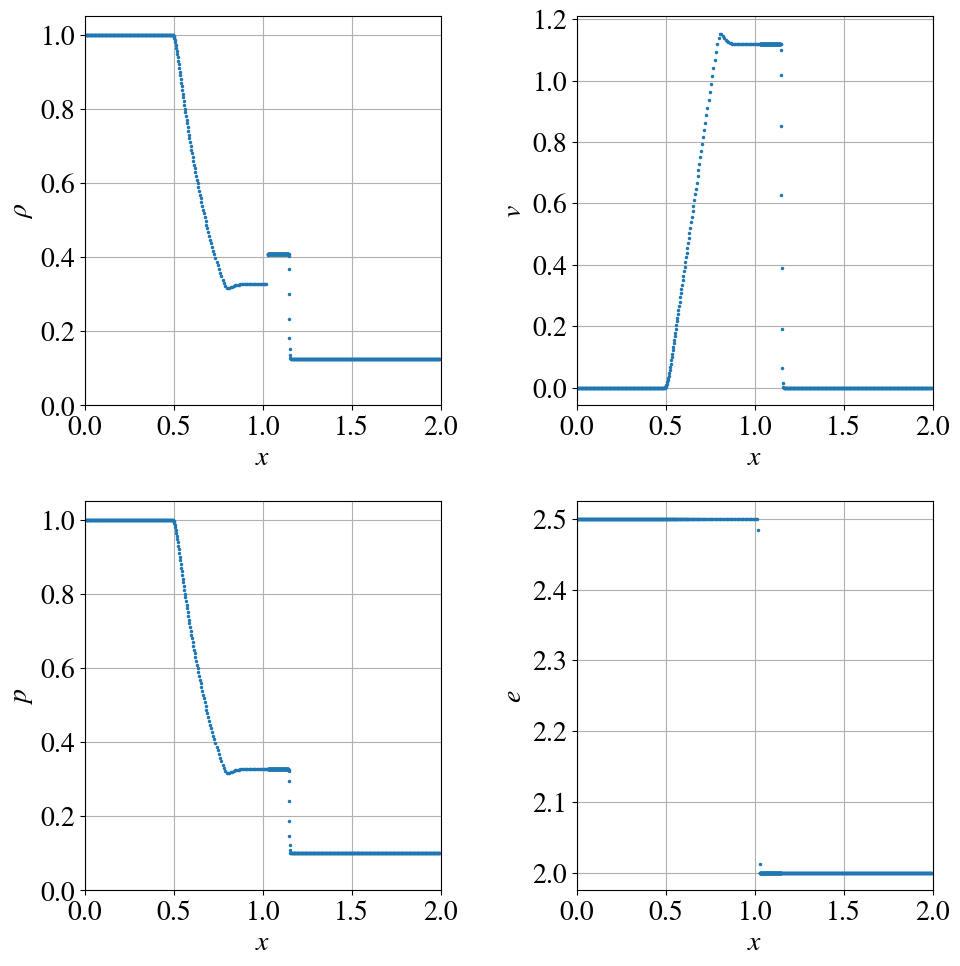

In [334]:
fig=plt.figure(figsize=(10,10),dpi=100)
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)

ax1.plot(x0[1:-2],rho0[1:-1],'.',markersize=3)
ax2.plot(x0[1:-2],v0[1:-2],'.',markersize=3)
ax3.plot(x0[1:-2],p0[1:-1],'.',markersize=3)
ax4.plot(x0[1:-2],e0[1:-1],'.',markersize=3)

ax1.set_xlim(0,2)
ax2.set_xlim(0,2)
ax3.set_xlim(0,2)
ax4.set_xlim(0,2)
ax1.set_ylim(0,1.05)
ax3.set_ylim(0,1.05)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$\rho$')
ax2.set_xlabel('$x$')
ax2.set_ylabel(r'$v$')
ax3.set_xlabel('$x$')
ax3.set_ylabel(r'$p$')
ax4.set_xlabel('$x$')
ax4.set_ylabel(r'$e$')

plt.tight_layout()

## 2. (b)

<font size="5">
Another artifacts I can see are wiggles in the profiles.<br>
I increased the cell number to 800 and reduced the CFL factor to 0.1.<br>
The results show less wiggles but still, density profile behaves in different way from the analytic solution.</font>

End: 145
Time: 0.2463734813660765


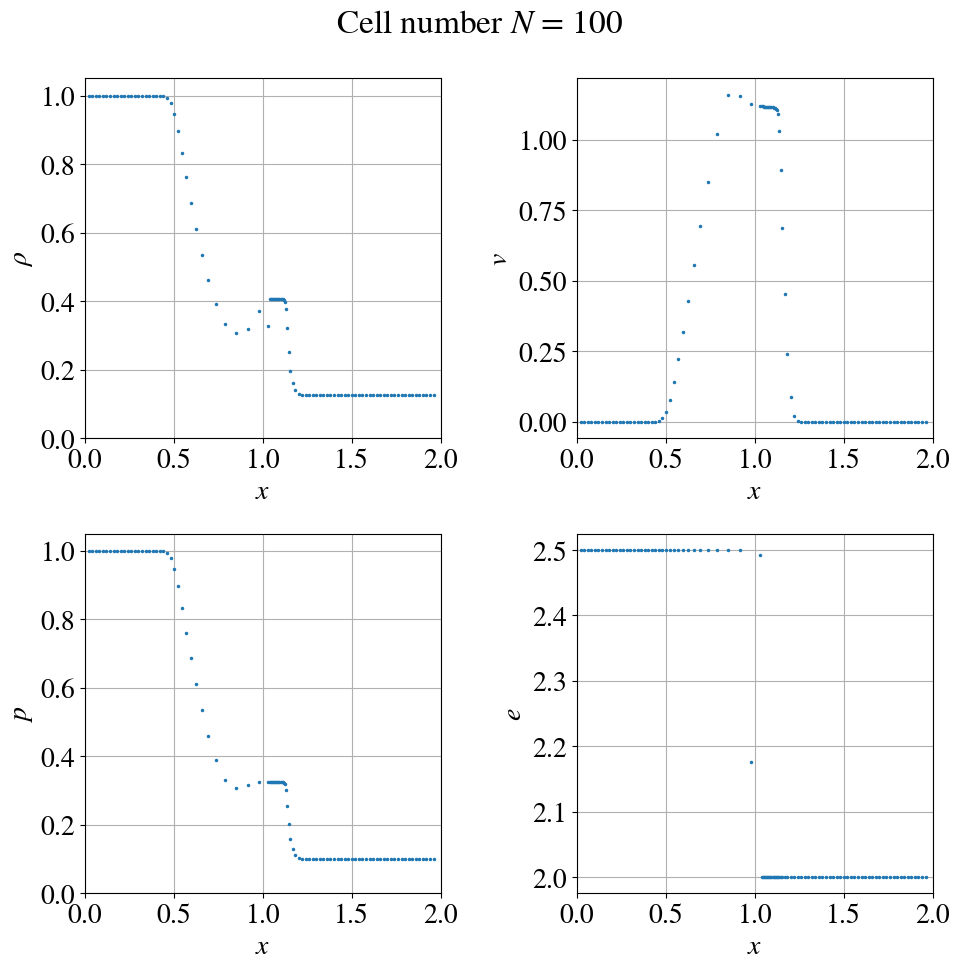

In [342]:
#constants
size=100
xlength=2
gamma=1.4
CFL=0.5

time=0

q_0=4
q_1=0.5


# empty arrays, one ghost cell at each end
rho0=np.zeros(size)
rho1=np.zeros(size)
m0=np.zeros(size)
m1=np.zeros(size)
p0=np.zeros(size)
p1=np.zeros(size)
q0=np.zeros(size)
q1=np.zeros(size)

v0=np.zeros(size+1)
v1=np.zeros(size+1)

x0=np.linspace(0,xlength,size+1)
x1=np.zeros(size+1)


# initialization
xmax=0.75
imax=int(size*xmax/xlength+1)

rho0[:imax]=1
p0[:imax]=1

rho0[imax:]=0.125
p0[imax:]=0.1


m0[:]=rho0[:]*(x0[-1]-x0[0])/size

v0[:]=0

e0=p0/rho0/(gamma-1)
e1=e0

cs0=np.sqrt(p0/rho0)
cs1=np.sqrt(p0/rho0)

q0[:]=0
        


for i in range(1000): #10000
    # timestep (n) - CFL condition
    delta_t=CFL*min(np.min((x0[1:]-x0[:-1])/(np.abs(v0[:-1])+cs0)), np.min((x0[1:]-x0[:-1])/(np.abs(v0[1:])+cs0)))
    #if i == 0:
        #delta_t*=0.0001
    #print(delta_t, time)


    # evolution (n+1/2)
    v1[1:-1]=v0[1:-1]-delta_t*(p0[1:]-p0[:-1]+q0[1:]-q0[:-1])/(0.5*(m0[:-1]+m0[1:]))
    v1[0]=0 # boundary
    v1[-1]=0 # boundary
    #time+=delta_t

    
    # timestep (n+1/2) - CFL condition
    #delta_t=CFL*np.min((x0[1:]-x0[:-1])/(np.abs(v1[1:])+cs0))
    #print(delta_t, time)


    # evolution (n+1)
    x1[:]=x0+delta_t*v1
    rho1[:]=m0/(x1[1:]-x1[:-1])
    #e1[:]=e0-(p0+q0)*(1/rho1-1/rho0)
    e1[:]=(e0-(p0/2+q0)*(1/rho1-1/rho0))/(1+rho1*(gamma-1)/2*(1/rho1-1/rho0))
    p1[:]=e1*rho1*(gamma-1)
    cs1[:]=np.sqrt(p1/rho1)
    time+=delta_t
    
    
    # artificial viscosity
    for j in range(size):
        if (v1[j+1]-v1[j])/(x1[j+1]-x1[j]) < 0:
            q1[j]=(q_0*(v1[j+1]-v1[j])**2-q_1*(v1[j+1]-v1[j]))*cs1[j]/(0.5*(1/rho1[j]+1/rho0[j]))
        else:
            q1[j]=0
    

    # ready to iterate
    rho0=rho1
    p0=p1
    q0=q1
    e0=e1
    cs0=cs1

    v0=v1
    x0=x1

    
    if time>0.245:
        print('End:',i)
        break

        
print('Time:',time)



fig=plt.figure(figsize=(10,10),dpi=100)

ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)

ax1.plot(x0[1:-2],rho0[1:-1],'.',markersize=3)
ax2.plot(x0[1:-2],v0[1:-2],'.',markersize=3)
ax3.plot(x0[1:-2],p0[1:-1],'.',markersize=3)
ax4.plot(x0[1:-2],e0[1:-1],'.',markersize=3)

ax1.set_xlim(0,2)
ax2.set_xlim(0,2)
ax3.set_xlim(0,2)
ax4.set_xlim(0,2)
ax1.set_ylim(0,1.05)
ax3.set_ylim(0,1.05)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$\rho$')
ax2.set_xlabel('$x$')
ax2.set_ylabel(r'$v$')
ax3.set_xlabel('$x$')
ax3.set_ylabel(r'$p$')
ax4.set_xlabel('$x$')
ax4.set_ylabel(r'$e$')

fig.suptitle('Cell number $N$ = {}'.format(size))
plt.tight_layout()

End: 305
Time: 0.24501793991738946


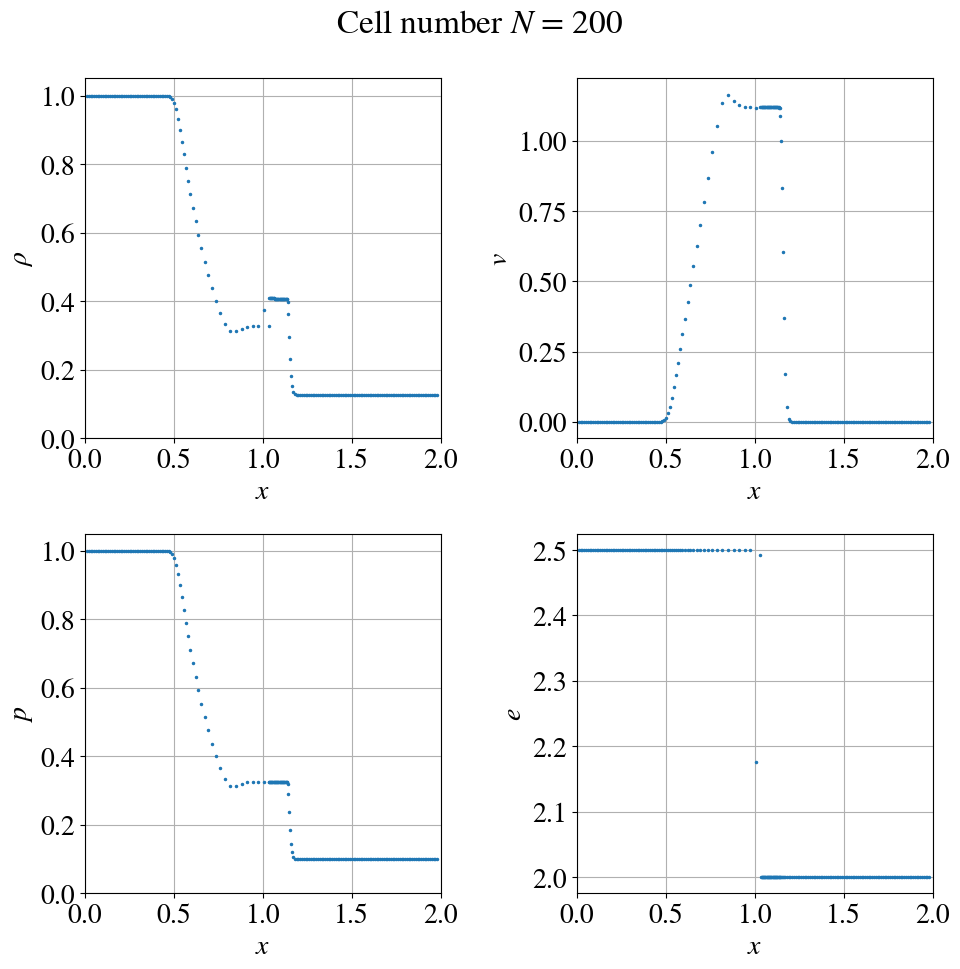

In [343]:
#constants
size=200
xlength=2
gamma=1.4
CFL=0.5

time=0

q_0=4
q_1=0.5


# empty arrays, one ghost cell at each end
rho0=np.zeros(size)
rho1=np.zeros(size)
m0=np.zeros(size)
m1=np.zeros(size)
p0=np.zeros(size)
p1=np.zeros(size)
q0=np.zeros(size)
q1=np.zeros(size)

v0=np.zeros(size+1)
v1=np.zeros(size+1)

x0=np.linspace(0,xlength,size+1)
x1=np.zeros(size+1)


# initialization
xmax=0.75
imax=int(size*xmax/xlength+1)

rho0[:imax]=1
p0[:imax]=1

rho0[imax:]=0.125
p0[imax:]=0.1


m0[:]=rho0[:]*(x0[-1]-x0[0])/size

v0[:]=0

e0=p0/rho0/(gamma-1)
e1=e0

cs0=np.sqrt(p0/rho0)
cs1=np.sqrt(p0/rho0)

q0[:]=0
        


for i in range(1000): #10000
    # timestep (n) - CFL condition
    delta_t=CFL*min(np.min((x0[1:]-x0[:-1])/(np.abs(v0[:-1])+cs0)), np.min((x0[1:]-x0[:-1])/(np.abs(v0[1:])+cs0)))
    #if i == 0:
        #delta_t*=0.0001
    #print(delta_t, time)


    # evolution (n+1/2)
    v1[1:-1]=v0[1:-1]-delta_t*(p0[1:]-p0[:-1]+q0[1:]-q0[:-1])/(0.5*(m0[:-1]+m0[1:]))
    v1[0]=0 # boundary
    v1[-1]=0 # boundary
    #time+=delta_t

    
    # timestep (n+1/2) - CFL condition
    #delta_t=CFL*np.min((x0[1:]-x0[:-1])/(np.abs(v1[1:])+cs0))
    #print(delta_t, time)


    # evolution (n+1)
    x1[:]=x0+delta_t*v1
    rho1[:]=m0/(x1[1:]-x1[:-1])
    #e1[:]=e0-(p0+q0)*(1/rho1-1/rho0)
    e1[:]=(e0-(p0/2+q0)*(1/rho1-1/rho0))/(1+rho1*(gamma-1)/2*(1/rho1-1/rho0))
    p1[:]=e1*rho1*(gamma-1)
    cs1[:]=np.sqrt(p1/rho1)
    time+=delta_t
    
    
    # artificial viscosity
    for j in range(size):
        if (v1[j+1]-v1[j])/(x1[j+1]-x1[j]) < 0:
            q1[j]=(q_0*(v1[j+1]-v1[j])**2-q_1*(v1[j+1]-v1[j]))*cs1[j]/(0.5*(1/rho1[j]+1/rho0[j]))
        else:
            q1[j]=0
    

    # ready to iterate
    rho0=rho1
    p0=p1
    q0=q1
    e0=e1
    cs0=cs1

    v0=v1
    x0=x1

    
    if time>0.245:
        print('End:',i)
        break

        
print('Time:',time)



fig=plt.figure(figsize=(10,10),dpi=100)

ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)

ax1.plot(x0[1:-2],rho0[1:-1],'.',markersize=3)
ax2.plot(x0[1:-2],v0[1:-2],'.',markersize=3)
ax3.plot(x0[1:-2],p0[1:-1],'.',markersize=3)
ax4.plot(x0[1:-2],e0[1:-1],'.',markersize=3)

ax1.set_xlim(0,2)
ax2.set_xlim(0,2)
ax3.set_xlim(0,2)
ax4.set_xlim(0,2)
ax1.set_ylim(0,1.05)
ax3.set_ylim(0,1.05)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$\rho$')
ax2.set_xlabel('$x$')
ax2.set_ylabel(r'$v$')
ax3.set_xlabel('$x$')
ax3.set_ylabel(r'$p$')
ax4.set_xlabel('$x$')
ax4.set_ylabel(r'$e$')

fig.suptitle('Cell number $N$ = {}'.format(size))
plt.tight_layout()

End: 627
Time: 0.24506517348223267


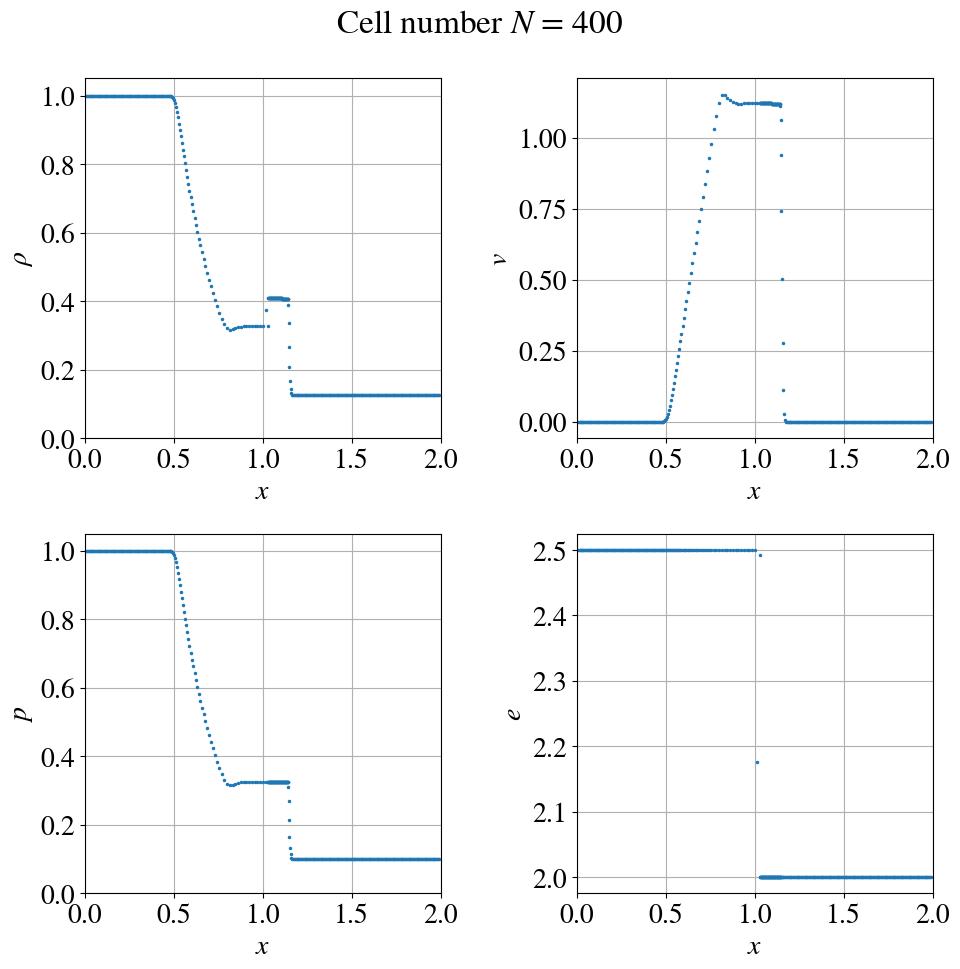

In [344]:
#constants
size=400
xlength=2
gamma=1.4
CFL=0.5

time=0

q_0=4
q_1=0.5


# empty arrays, one ghost cell at each end
rho0=np.zeros(size)
rho1=np.zeros(size)
m0=np.zeros(size)
m1=np.zeros(size)
p0=np.zeros(size)
p1=np.zeros(size)
q0=np.zeros(size)
q1=np.zeros(size)

v0=np.zeros(size+1)
v1=np.zeros(size+1)

x0=np.linspace(0,xlength,size+1)
x1=np.zeros(size+1)


# initialization
xmax=0.75
imax=int(size*xmax/xlength+1)

rho0[:imax]=1
p0[:imax]=1

rho0[imax:]=0.125
p0[imax:]=0.1


m0[:]=rho0[:]*(x0[-1]-x0[0])/size

v0[:]=0

e0=p0/rho0/(gamma-1)
e1=e0

cs0=np.sqrt(p0/rho0)
cs1=np.sqrt(p0/rho0)

q0[:]=0
        


for i in range(1000): #10000
    # timestep (n) - CFL condition
    delta_t=CFL*min(np.min((x0[1:]-x0[:-1])/(np.abs(v0[:-1])+cs0)), np.min((x0[1:]-x0[:-1])/(np.abs(v0[1:])+cs0)))
    #if i == 0:
        #delta_t*=0.0001
    #print(delta_t, time)


    # evolution (n+1/2)
    v1[1:-1]=v0[1:-1]-delta_t*(p0[1:]-p0[:-1]+q0[1:]-q0[:-1])/(0.5*(m0[:-1]+m0[1:]))
    v1[0]=0 # boundary
    v1[-1]=0 # boundary
    #time+=delta_t

    
    # timestep (n+1/2) - CFL condition
    #delta_t=CFL*np.min((x0[1:]-x0[:-1])/(np.abs(v1[1:])+cs0))
    #print(delta_t, time)


    # evolution (n+1)
    x1[:]=x0+delta_t*v1
    rho1[:]=m0/(x1[1:]-x1[:-1])
    #e1[:]=e0-(p0+q0)*(1/rho1-1/rho0)
    e1[:]=(e0-(p0/2+q0)*(1/rho1-1/rho0))/(1+rho1*(gamma-1)/2*(1/rho1-1/rho0))
    p1[:]=e1*rho1*(gamma-1)
    cs1[:]=np.sqrt(p1/rho1)
    time+=delta_t
    
    
    # artificial viscosity
    for j in range(size):
        if (v1[j+1]-v1[j])/(x1[j+1]-x1[j]) < 0:
            q1[j]=(q_0*(v1[j+1]-v1[j])**2-q_1*(v1[j+1]-v1[j]))*cs1[j]/(0.5*(1/rho1[j]+1/rho0[j]))
        else:
            q1[j]=0
    

    # ready to iterate
    rho0=rho1
    p0=p1
    q0=q1
    e0=e1
    cs0=cs1

    v0=v1
    x0=x1

    
    if time>0.245:
        print('End:',i)
        break

        
print('Time:',time)



fig=plt.figure(figsize=(10,10),dpi=100)

ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)

ax1.plot(x0[1:-2],rho0[1:-1],'.',markersize=3)
ax2.plot(x0[1:-2],v0[1:-2],'.',markersize=3)
ax3.plot(x0[1:-2],p0[1:-1],'.',markersize=3)
ax4.plot(x0[1:-2],e0[1:-1],'.',markersize=3)

ax1.set_xlim(0,2)
ax2.set_xlim(0,2)
ax3.set_xlim(0,2)
ax4.set_xlim(0,2)
ax1.set_ylim(0,1.05)
ax3.set_ylim(0,1.05)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$\rho$')
ax2.set_xlabel('$x$')
ax2.set_ylabel(r'$v$')
ax3.set_xlabel('$x$')
ax3.set_ylabel(r'$p$')
ax4.set_xlabel('$x$')
ax4.set_ylabel(r'$e$')

fig.suptitle('Cell number $N$ = {}'.format(size))
plt.tight_layout()

# 2. (c)

<font size="5">
Even with $N=100$, the solution converges quite well.<br>
I guess about 100 numerical elements can resolve the solution in our numerical scheme.<br>
The number 100 seems to be reasonable.</font>